In [1]:
import neo4j
import pandas as pd
from utils import simplify_to_centroid_if_small
from utils_neo4j import init, station_insert_query
from geofox_client import get_geofox_client
from utils_geofox import get_stations, stationdf2rows, get_departures, process_departure_data
import pandas as pd
import json

c:\Users\paul-\anaconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load departures preproc from json
departures_preproc = pd.read_json("data_geofox/departures_all_preproc.json")

In [3]:
mask = ~departures_preproc.next_station.isna()
departures_preproc = departures_preproc[mask]

In [4]:
mask = departures_preproc.from_station == departures_preproc.next_station
departures_preproc = departures_preproc[~mask]

In [5]:
departures_preproc

,from_station,from_station_id,line_terminal,line_origin,line_id,line_name,line_info,direction_id,departure_time,platform,next_station,arrival_time
0,Berliner Tor,Master:10952,Jungfernstieg,Hammer Kirche,HHA-U:U2_HHA-U,U2,U-Bahn,6,2025-04-03 00:01:00,Gleis 3,Hammer Kirche,2025-04-03 00:02:00
1,Berliner Tor,Master:10952,Hammer Kirche,Jungfernstieg,HHA-U:U2_HHA-U,U2,U-Bahn,1,2025-04-03 00:02:00,Gleis 2,Burgstraße,2025-04-03 00:04:00
2,Berliner Tor,Master:10952,Ohlsdorf,Elbgaustraße,SBH:S5_SBH_SBAHNS,S5,S-Bahn,1,2025-04-03 00:04:00,Gleis 3 (S-Bahn),Landwehr,2025-04-03 00:07:00
3,Billhorner Deich,Master:10000,U Steinfurther Allee,U S Elbbrücken (Baakenwerder Straße),VHH:119_VHH,119,Niederflur Stadtbus,1,2025-04-03 00:05:00,,Thiedingreihe,2025-04-03 00:06:00
4,Hauptbahnhof/ZOB,Master:10002,U S Berliner Tor (Beim Strohhause),"Schenefeld, Busbetriebshof",VHH:2_VHH,2,Niederflur Metrobus,1,2025-04-03 00:05:00,,Kurt-Schumacher-Allee,2025-04-03 00:07:00
...,...,...,...,...,...,...,...,...,...,...,...,...
644318,Hauptbahnhof Nord,Master:10905,Niendorf Nord,Hammer Kirche,HHA-U:U2_HHA-U,U2,U-Bahn,6,2025-04-03 23:58:00,Gleis 2,Joachim-Mähl-Straße,2025-04-03 23:59:00
644319,Hauptbahnhof Süd,Master:10906,Schlump - Barmbek,Wandsbek-Gartenstadt,HHA-U:U3_HHA-U,U3,U-Bahn,6,2025-04-03 23:58:00,Gleis 4,Feldstraße (Heiligengeistfeld),2025-04-03 23:59:00
644321,HBF/Steintorwall,Master:10001,"Schenefeld, Schenefelder Platz",U S Berliner Tor (Beim Strohhause),VHH:2_VHH,2,Niederflur Metrobus,6,2025-04-03 23:58:00,,Ericusspitze,2025-04-04 00:00:00
644322,Hamburg Hbf,Master:10950,Wedel,Poppenbüttel,ZVU-DB:S1_ZVU-DB_SBHZVU,S1,S-Bahn,6,2025-04-03 23:58:00,Gleis 1 (S-Bahn),Ohlsdorf,2025-04-03 23:59:00


In [6]:
len(departures_preproc)

636528

In [51]:
def process_transit_data(df):
    # Create a unique line identifier by combining line_id, origin, and terminal
    df['unique_line'] = df['line_id'] + '#' + df['line_origin'] + '#' + df['line_terminal'] + '#' + df['direction_id'].astype(str)
    
    # Calculate duration in minutes
    df['departure_time'] = pd.to_datetime(df['departure_time'])
    df['arrival_time'] = pd.to_datetime(df['arrival_time'])
    df['duration_minutes'] = (df['arrival_time'] - df['departure_time']).dt.total_seconds() / 60
    
    # Group data by from_station, from_station_id, next_station, and unique_line to combine same lines
    # Note: We're assuming that next_station has an ID too, but it's not in the sample data
    # You may need to add next_station_id to the groupby if it exists in your full dataset
    grouped = df.groupby(['from_station', 'from_station_id', 'next_station', 'unique_line'])
    
    # Store the processed relationships
    relationships = []
    
    for (from_station, from_station_id, to_station, unique_line), group in grouped:
        # Extract the consistent properties
        line_name = group['line_name'].iloc[0]
        line_info = group['line_info'].iloc[0]
        
        # Extract the lists of departure times and arrival times
        # Convert to sets first to ensure uniqueness, then sort for consistency
        departure_times_set = set(group['departure_time'].dt.strftime('%Y-%m-%d %H:%M:%S'))
        arrival_times_set = set(group['arrival_time'].dt.strftime('%Y-%m-%d %H:%M:%S'))
        
        # Convert back to sorted lists
        departure_times = sorted(list(departure_times_set))
        arrival_times = sorted(list(arrival_times_set))
        
        # Calculate average duration (should be consistent, but just in case)
        avg_duration = group['duration_minutes'].min().astype(int).item()
        
        # Create a relationship object
        rel_data = {
            'from_station': from_station,
            'from_station_id': from_station_id,
            'to_station': to_station,
            'line_unique': unique_line,
            'line_name': line_name,
            'line_info': line_info,
            'departure_times': departure_times,
            'arrival_times': arrival_times,
            'duration': avg_duration
        }
        
        relationships.append(rel_data)
    
    return relationships

In [52]:
res = process_transit_data(departures_preproc)

In [53]:
len(res)

65323

In [54]:
# load res into pandas dataframe
df = pd.DataFrame(res)
df.sample(100)

,from_station,from_station_id,to_station,line_unique,line_name,line_info,departure_times,arrival_times,duration
58437,U S Barmbek,Master:70028,Gymnasium Marienthal,HHA-B:261_HHA-B#U S Barmbek#U Burgstraße#1,261,Niederflur Stadtbus,"[2025-04-03 13:07:00, 2025-04-03 13:27:00, 202...","[2025-04-03 13:08:00, 2025-04-03 13:28:00, 202...",1
58291,U Rödingsmarkt (Großer Burstah),Master:11004,Hebebrandstraße,HHA-B:607_HHA-B#S Poppenbüttel (Wentzelplatz)#...,607,Niederflur-Nachtbus,[2025-04-03 03:31:00],[2025-04-03 03:32:00],1
63220,Werner-Otto-Straße (Mitte),Master:63000,Rahnstraße,HHA-B:8_HHA-B#U Wandsbek-Gartenstadt#S Poppenb...,8,Niederflur Metrobus,[2025-04-03 07:15:00],[2025-04-03 07:18:00],3
50871,Seumestraße,Master:60017,Groß Flottbeker Straße,HHA-B:16_HHA-B#Elbe-Einkaufszentrum#Bf. Rahlst...,16,Niederflur Metrobus,"[2025-04-03 07:44:00, 2025-04-03 08:44:00, 202...","[2025-04-03 07:46:00, 2025-04-03 08:46:00, 202...",1
4428,August-Kirch-Straße,Master:80055,Rathaus Altona,VHH:2_VHH#U S Berliner Tor (Beim Strohhause)#S...,2,Niederflur Metrobus,"[2025-04-03 12:26:00, 2025-04-03 12:47:00, 202...","[2025-04-03 12:28:00, 2025-04-03 12:48:00, 202...",1
...,...,...,...,...,...,...,...,...,...
38570,Neugrabener Markt,Master:41038,S Neugraben,HHA-B:40_HHA-B#Waldfrieden (Kehre)#Neu Wulmsto...,40,Niederflur Metrobus,"[2025-04-03 05:56:00, 2025-04-03 06:56:00, 202...","[2025-04-03 05:59:00, 2025-04-03 06:59:00, 202...",3
60211,U Wartenau,Master:60015,Davidstraße,HHA-B:16_HHA-B#Rentenversicherung Nord#EEZ (Ju...,16,Niederflur Metrobus,[2025-04-03 07:22:00],[2025-04-03 07:23:00],1
14295,Engelbrechtweg,Master:82017,Vielohwisch,VHH:21_VHH#U Niendorf Nord#Teufelsbrück (Fähre)#1,21,Niederflur Metrobus,[2025-04-03 21:04:00],[2025-04-03 21:05:00],1
26467,Holtenklinke,Master:26006,Unterm Heilbrunnen,"VHH:8890_VHH#Neu Börnsen, Zwischen den Kreisel...",8890,Niederflur Stadtbus,"[2025-04-03 06:44:00, 2025-04-03 07:14:00, 202...","[2025-04-03 06:46:00, 2025-04-03 07:17:00, 202...",2


In [62]:
mask = df.duration > 40
print(len(df[mask]))
df = df[~mask]

352


In [63]:
# For a more detailed analysis, you can also check stations with the same name but different IDs
same_name_diff_id = df[df.duplicated(['from_station', 'to_station', 'line_unique'], keep=False)]
if len(same_name_diff_id) > 0:
    # Sort to group duplicates together
    same_name_diff_id = same_name_diff_id.sort_values(['from_station', 'to_station', 'line_unique'])
    
    print(f"\nFound {len(same_name_diff_id)} rows with potential duplicate routes (same stations and line but different IDs):")
    
    # Group by the duplicated columns to analyze each set separately
    for (from_station, to_station, line_unique), group in same_name_diff_id.groupby(['from_station', 'to_station', 'line_unique']):
        print(f"\nDuplicate Route: {from_station} → {to_station}, Line: {line_unique}")
        print(f"Number of duplicates: {len(group)}")
        
        # Print the station IDs for each duplicate
        for idx, row in group.iterrows():
            print(f"  From Station ID: {row['from_station_id']}")
        
        # Check if the departure times are the same or different
        all_departure_times = [set(row['departure_times']) for idx, row in group.iterrows()]
        if all(times == all_departure_times[0] for times in all_departure_times):
            print("  All duplicates have the same departure times.")
        else:
            print("  Duplicates have different departure times.")
else:
    print("\nNo duplicate routes (same stations and line) found.")


No duplicate routes (same stations and line) found.


In [68]:
def find_duplicate_lines_on_stations(df):
    # Current Date and Time (UTC): 2025-04-06 10:40:12
    # Current User's Login: virsel

    # Check for cases where the same from_station_id and line_unique go to different to_station
    # Group by from_station_id and line_unique
    grouped = df.groupby(['from_station_id', 'line_unique'])

    # Find groups with more than one unique to_station
    problematic_groups = []
    for (station_id, line), group in grouped:
        unique_destinations = group['to_station'].unique()
        if len(unique_destinations) > 1:
            problematic_groups.append({
                'from_station_id': station_id,
                'from_station': group['from_station'].iloc[0],  # Get the station name
                'line_unique': line,
                'line_name': group['line_name'].iloc[0],
                'destinations': unique_destinations.tolist(),
                'count': len(unique_destinations)
            })

    # Display results
    if problematic_groups:
        print(f"Found {len(problematic_groups)} cases where the same from_station_id and line_unique go to different destination stations:")
        
        for i, case in enumerate(problematic_groups):
            print(f"\nCase {i+1}:")
            print(f"  From Station: {case['from_station']} (ID: {case['from_station_id']})")
            print(f"  Line: {case['line_unique']} ({case['line_name']})")
            print(f"  Destinations: {', '.join(case['destinations'])} ({case['count']} different destinations)")
            
            # Get the detailed rows for this problematic case
            detail_rows = df[(df['from_station_id'] == case['from_station_id']) & 
                            (df['line_unique'] == case['line_unique'])]
            
            # Display details for each destination
            print("\n  Details:")
            for dest in case['destinations']:
                dest_rows = detail_rows[detail_rows['to_station'] == dest]
                print(f"    → Destination: {dest}")
                print(f"      Departure times count: {len(dest_rows.iloc[0]['departure_times'])}")
                print(f"      Duration: {dest_rows.iloc[0]['duration']} minutes")
                
                # Show a few departure times as sample
                sample_times = dest_rows.iloc[0]['departure_times'][:3]
                print(f"      Sample departure times: {sample_times}...")
    else:
        print("No cases found where the same from_station_id and line_unique go to different destination stations.")

    # Summary statistics
    print("\nSummary:")
    print(f"Total relationships in DataFrame: {len(df)}")
    print(f"Total unique stations: {df['from_station_id'].nunique()}")
    print(f"Total unique lines: {df['line_unique'].nunique()}")
    print(f"Problematic combinations: {len(problematic_groups)}")

In [66]:
# Current Date and Time (UTC): 2025-04-06 10:47:19
# Current User's Login: virsel

def clean_ambiguous_destinations(df):
    """
    Clean dataframe by removing ambiguous destinations for the same from_station+line_unique combination.
    When a station and line combination leads to multiple destinations, keep only the destination with:
    1. Lowest duration (primary criterion)
    2. Highest number of departure times (secondary criterion, used as tiebreaker)
    
    Args:
        df: DataFrame with transit data
        
    Returns:
        Cleaned DataFrame with unique from_station_id+line_unique combinations
    """
    print("Checking for ambiguous destinations...")
    
    # Find all problematic combinations (from_station_id + line_unique → multiple destinations)
    grouped = df.groupby(['from_station_id', 'line_unique'])
    problem_groups = []
    
    for (station_id, line), group in grouped:
        if len(group['to_station'].unique()) > 1:
            problem_groups.append((station_id, line))
    
    if not problem_groups:
        print("No ambiguous destinations found. All from_station+line combinations lead to a single destination.")
        return df
    
    # Create a copy of the dataframe to avoid modifying the original
    df_clean = df.copy()
    
    # Process each problematic combination
    fixed_count = 0
    for station_id, line in problem_groups:
        # Extract the group with this combination
        group = df_clean[(df_clean['from_station_id'] == station_id) & 
                         (df_clean['line_unique'] == line)].copy()
        
        # Add a helper column with departure count
        group['departure_count'] = group['departure_times'].apply(len)
        
        # Sort by duration (ascending) then by departure_count (descending)
        group = group.sort_values(by=['duration', 'departure_count'], 
                                  ascending=[True, False])
        
        # Get details for logging
        station_name = group['from_station'].iloc[0]
        line_name = group['line_name'].iloc[0]
        
        # Get the preferred destination (lowest duration, highest departure count)
        preferred = group.iloc[0]
        preferred_dest = preferred['to_station']
        rejected_dests = group['to_station'].iloc[1:].tolist()
        
        # Remove all rows except the preferred one
        indices_to_drop = group.index[1:]
        df_clean = df_clean.drop(indices_to_drop)
        
        # Log the action
        print(f"\nFixed ambiguous destination for {station_name} (ID: {station_id}) on line {line_name}:")
        print(f"  Kept destination: {preferred_dest} (Duration: {preferred['duration']} min, Departures: {preferred['departure_count']})")
        print(f"  Removed destinations: {', '.join(rejected_dests)}")
        
        fixed_count += 1
    
    # Print summary
    print(f"\nCleaning complete! Fixed {fixed_count} ambiguous destination issues.")
    print(f"Original row count: {len(df)}")
    print(f"Cleaned row count: {len(df_clean)}")
    print(f"Removed {len(df) - len(df_clean)} rows")
    
    return df_clean

In [67]:
# Apply the cleaning function
df_cleaned = clean_ambiguous_destinations(df)

Checking for ambiguous destinations...

Fixed ambiguous destination for Billhorner Deich (ID: Master:10000) on line 119:
  Kept destination: Billstedter Hauptstraße (Duration: 1 min, Departures: 24)
  Removed destinations: Thiedingreihe, Sonnenland, Schleemer Weg (Nord)

Fixed ambiguous destination for Billhorner Deich (ID: Master:10000) on line 119:
  Kept destination: Rothenburgsorter Marktplatz (Duration: 1 min, Departures: 27)
  Removed destinations: Berzeliusstraße (Mitte), Oststeinbeker Weg (Mitte)

Fixed ambiguous destination for Billhorner Deich (ID: Master:10000) on line 122:
  Kept destination: Lehfeld (Duration: 1 min, Departures: 1)
  Removed destinations: Am Bergedorfer Hafen, Bf. Bergedorf, S Rothenburgsort

Fixed ambiguous destination for Billhorner Deich (ID: Master:10000) on line 122:
  Kept destination: Am Bergedorfer Hafen (Duration: 1 min, Departures: 5)
  Removed destinations: Bf. Bergedorf, Thiedingreihe, Am Schleusengraben

Fixed ambiguous destination for Billhor

In [69]:
find_duplicate_lines_on_stations(df_cleaned)

No cases found where the same from_station_id and line_unique go to different destination stations.

Summary:
Total relationships in DataFrame: 23871
Total unique stations: 2225
Total unique lines: 1567
Problematic combinations: 0


In [70]:
df_cleaned

,from_station,from_station_id,to_station,line_unique,line_name,line_info,departure_times,arrival_times,duration
0,A Burgwedel,Master:86007,Basselweg,HHA-B:603_HHA-B#Grothwisch#Rathausmarkt#1,603,Niederflur-Nachtbus,[2025-04-03 01:02:00],[2025-04-03 01:03:00],1
4,A Burgwedel,Master:86007,Freizeitbad Bondenwald,HHA-B:5_HHA-B#A Burgwedel#Hauptbahnhof/ZOB#1,5,Niederflur Metrobus,"[2025-04-03 07:05:00, 2025-04-03 07:15:00, 202...","[2025-04-03 07:06:00, 2025-04-03 07:16:00, 202...",1
8,A Burgwedel,Master:86007,Graf-Otto-Weg,HHA-B:603_HHA-B#Rathausmarkt#Grothwisch#6,603,Niederflur-Nachtbus,"[2025-04-03 01:56:00, 2025-04-03 02:26:00, 202...","[2025-04-03 01:57:00, 2025-04-03 02:27:00, 202...",1
17,A Eidelstedt Zentrum,Master:83013,Behrmannplatz,VHH:281_VHH#S Krupunder#U Lattenkamp#1,281,Niederflur Stadtbus,"[2025-04-03 07:26:00, 2025-04-03 07:46:00, 202...","[2025-04-03 07:27:00, 2025-04-03 07:48:00, 202...",1
20,A Eidelstedt Zentrum,Master:83013,Behrmannplatz,VHH:281_VHH#UK Eppendorf (Haupteingang)#S Krup...,281,Niederflur Stadtbus,"[2025-04-03 07:22:00, 2025-04-03 07:42:00, 202...","[2025-04-03 07:23:00, 2025-04-03 07:43:00, 202...",1
...,...,...,...,...,...,...,...,...,...
65310,Überseering (West),Master:70017,Goebenstraße,HHA-B:20_HHA-B#S Rübenkamp#Bf. Altona#6,20,Niederflur Metrobus,"[2025-04-03 09:15:00, 2025-04-03 09:25:00, 202...","[2025-04-03 09:16:00, 2025-04-03 09:26:00, 202...",1
65311,Überseering (West),Master:70017,Heinrich-Traun-Platz,HHA-B:179_HHA-B#U Borgweg#S Poppenbüttel (Went...,179,Niederflur Stadtbus,[2025-04-03 19:30:00],[2025-04-03 19:31:00],1
65314,Überseering (West),Master:70017,Jahnring (Mitte),HHA-B:20_HHA-B#S Rübenkamp#Winterhuder Marktpl...,20,Niederflur Metrobus,[2025-04-03 23:59:00],[2025-04-04 00:00:00],1
65315,Überseering (West),Master:70017,Kottwitzstraße,HHA-B:20_HHA-B#Bf. Altona#S Rübenkamp#1,20,Niederflur Metrobus,"[2025-04-03 06:54:00, 2025-04-03 07:04:00, 202...","[2025-04-03 06:55:00, 2025-04-03 07:05:00, 202...",1


<Axes: ylabel='Frequency'>

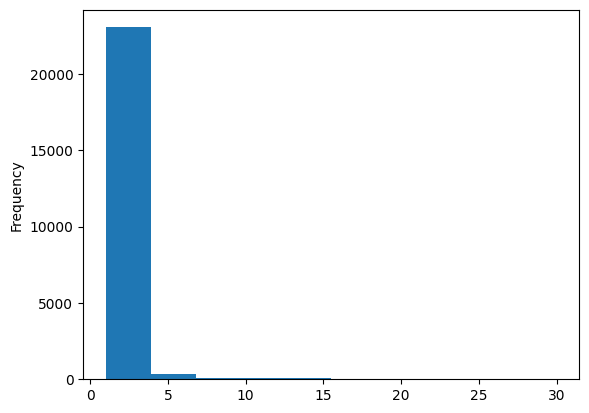

In [77]:
df_cleaned.duration.plot.hist()

In [76]:
mask = df_cleaned.duration > 30
print(len(df_cleaned[mask]))
df_cleaned = df_cleaned[~mask]

63


In [80]:
df_cleaned[df_cleaned.from_station == "Hamburg Hbf"]

,from_station,from_station_id,to_station,line_unique,line_name,line_info,departure_times,arrival_times,duration
22498,Hamburg Hbf,Master:10950,Bahrenfeld,ZVU-DB:S1_ZVU-DB_SBHZVU#Blankenese#Poppenbütte...,S1,S-Bahn,"[2025-04-03 05:54:00, 2025-04-03 09:54:00, 202...","[2025-04-03 05:56:00, 2025-04-03 09:56:00, 202...",2
22500,Hamburg Hbf,Master:10950,Bahrenfeld,ZVU-DB:S1_ZVU-DB_SBHZVU#Wedel#Poppenbüttel#1,S1,S-Bahn,"[2025-04-03 00:04:00, 2025-04-03 00:24:00]","[2025-04-03 00:06:00, 2025-04-03 00:26:00]",2
22501,Hamburg Hbf,Master:10950,Bergedorf,DB-EFZ:RE1_DB-EFZ_Z#Hamburg Hbf#Büchen#1,RE1,RegionalExpress,"[2025-04-03 05:57:00, 2025-04-03 06:54:00, 202...","[2025-04-03 06:08:00, 2025-04-03 07:07:00, 202...",11
22502,Hamburg Hbf,Master:10950,Bergedorf,DB-EFZ:RE1_DB-EFZ_Z#Hamburg Hbf#Rostock Hbf#1,RE1,RegionalExpress,[2025-04-03 22:54:00],[2025-04-03 23:07:00],13
22503,Hamburg Hbf,Master:10950,Bergedorf,DB-EFZ:RE1_DB-EFZ_Z#Hamburg Hbf#Schwaan#1,RE1,RegionalExpress,"[2025-04-03 06:21:00, 2025-04-03 08:21:00, 202...","[2025-04-03 06:32:00, 2025-04-03 08:32:00, 202...",11
...,...,...,...,...,...,...,...,...,...
22615,Hamburg Hbf,Master:10950,Langenfelde,SBH:S5_SBH_SBAHNS#Elbgaustraße#Berliner Tor#1,S5,S-Bahn,"[2025-04-03 22:02:00, 2025-04-03 22:22:00, 202...","[2025-04-03 22:03:00, 2025-04-03 22:23:00, 202...",1
22618,Hamburg Hbf,Master:10950,Ohlsdorf,ZVU-DB:S1_ZVU-DB_SBHZVU#Hamburg Airport (Flugh...,S1,S-Bahn,"[2025-04-03 08:48:00, 2025-04-03 09:08:00, 202...","[2025-04-03 08:49:00, 2025-04-03 09:09:00, 202...",1
22622,Hamburg Hbf,Master:10950,Ohlsdorf,ZVU-DB:S1_ZVU-DB_SBHZVU#Poppenbüttel#Wedel#6,S1,S-Bahn,"[2025-04-03 04:38:00, 2025-04-03 04:58:00, 202...","[2025-04-03 04:39:00, 2025-04-03 04:59:00, 202...",1
22632,Hamburg Hbf,Master:10950,Tiefstack,SBH:S2_SBH_SBAHNS#Aumühle#Altona#6,S2,S-Bahn,"[2025-04-03 06:18:00, 2025-04-03 06:28:00, 202...","[2025-04-03 06:19:00, 2025-04-03 06:29:00, 202...",1


In [81]:
# safe departures preproc2 to csv
df_cleaned.to_csv("data_geofox/departures_all_preproc2.csv", index=False)